In [28]:
import pandas as pd
import numpy as np
import os
import random

In [29]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

### 1.Data Preprocessing

In [30]:
train = pd.read_csv(r'C:\Users\User\Documents\Code\ML\MLP_From_Scratch\data\train.csv')
test = pd.read_csv(r'C:\Users\User\Documents\Code\ML\MLP_From_Scratch\data\test.csv')
df_train = train.copy().drop('ID_code', axis=1)
df_test = test.copy().drop('ID_code', axis=1)
df_train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, target to var_199
dtypes: float64(200), int64(1)
memory usage: 306.7 MB


#### Handle missing values

In [32]:
print(df_train.isna().sum().values.any())
print(df_test.isna().sum().values.any())

False
False


In [33]:
df_train['target'].value_counts(normalize=True)

target
0    0.89951
1    0.10049
Name: proportion, dtype: float64

#### Feature Engineering

In [34]:
def feature_engineering(df):
    df = df.copy()
    features = [col for col in df.columns if col != 'target']
    df['sum']  = df[features].sum(axis=1)  
    df['min']  = df[features].min(axis=1)
    df['max']  = df[features].max(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['std']  = df[features].std(axis=1)
    df['med']  = df[features].median(axis=1)
    return df

df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)
df_train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_196,var_197,var_198,var_199,sum,min,max,mean,std,med
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,7.8784,8.5635,12.7803,-1.0914,1456.3182,-21.4494,43.1127,7.281591,9.331540,6.77040
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,8.1267,8.7889,18.3560,1.9518,1415.3636,-47.3797,40.5632,7.076818,10.336130,7.22315
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,-6.5213,8.2675,14.7222,0.3965,1240.8966,-22.4038,33.8820,6.204483,8.753387,5.89940
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,-2.9275,10.2922,17.9697,-8.9996,1288.2319,-35.1659,38.1015,6.441159,9.594064,6.70260
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,3.9267,9.5031,17.9974,-8.8104,1354.2310,-65.4863,41.1037,6.771155,11.287122,6.94735


#### Standardization

In [35]:
class StandardScaler:
    def __init__(self):
        self.mean = []
        self.std = []
        self.features = []

    def fit(self, df):
        self.features = df.columns
        df = df.copy().values
        self.mean = np.mean(df, axis=0)
        self.std = np.std(df, axis=0)
        self.std[self.std == 0] = 1.0

    def transform(self, df):
        df_scaled = df.copy()
        df_scaled[self.features] = (df_scaled[self.features] - self.mean) / self.std
        return df_scaled

In [36]:
scaler = StandardScaler()
X_train = df_train.drop('target', axis=1)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(df_test)
y_train = df_train['target']

#### KFold

In [37]:
class StratifiedKFold:
    def __init__(self, n_splits=5, random_state=None):
        self.n_splits = n_splits
        self.random_state = random_state

    def split(self, X, y):
        X = X.copy().values
        y = y.copy().values
        np.random.seed(self.random_state)
        unique_classes, y_indices = np.unique(y, return_inverse=True)
        class_counts = np.bincount(y_indices)
        folds = [[] for _ in range(self.n_splits)]
        for cls in unique_classes:
            cls_indices = np.where(y == cls)[0]
            np.random.shuffle(cls_indices)
            fold_sizes = (class_counts[cls] // self.n_splits) * np.ones(self.n_splits, dtype=int)
            fold_sizes[:class_counts[cls] % self.n_splits] += 1
            current = 0
            for fold_idx in range(self.n_splits):
                start, stop = current, current + fold_sizes[fold_idx]
                folds[fold_idx].extend(cls_indices[start:stop])
                current = stop
        for fold_idx in range(self.n_splits):
            test_idx = folds[fold_idx]
            train_idx = [idx for i, fold in enumerate(folds) if i != fold_idx for idx in fold]
            yield train_idx, test_idx

### 2.Training

FOLD 1/5
Epoch 1/50, Train Loss: 0.3422, Val Loss: 0.2458
Epoch 11/50, Train Loss: 0.2563, Val Loss: 0.2368
Epoch 21/50, Train Loss: 0.2541, Val Loss: 0.2328
Epoch 31/50, Train Loss: 0.2518, Val Loss: 0.2321
Epoch 41/50, Train Loss: 0.2506, Val Loss: 0.2312
Epoch 50/50, Train Loss: 0.2507, Val Loss: 0.2313


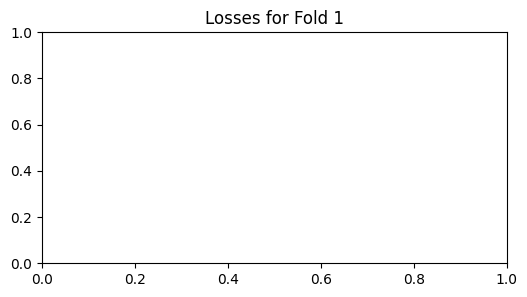

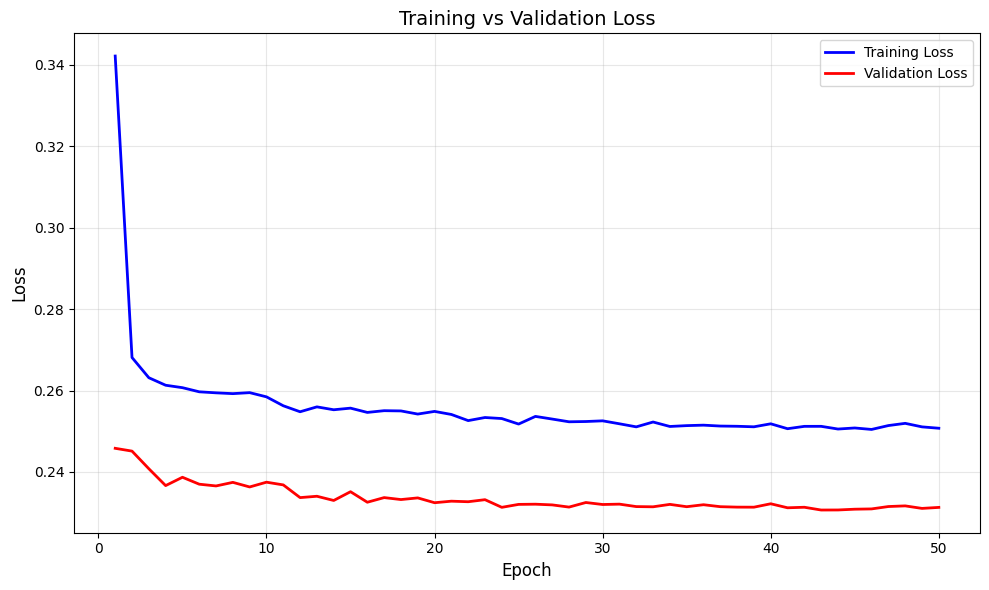

FOLD 2/5
Epoch 1/50, Train Loss: 0.3147, Val Loss: 0.2592
Epoch 11/50, Train Loss: 0.2624, Val Loss: 0.2478
Epoch 21/50, Train Loss: 0.2595, Val Loss: 0.2453
Epoch 31/50, Train Loss: 0.2579, Val Loss: 0.2444
Epoch 41/50, Train Loss: 0.2576, Val Loss: 0.2442
Epoch 50/50, Train Loss: 0.2576, Val Loss: 0.2438


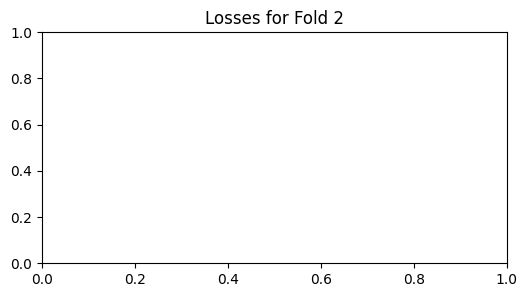

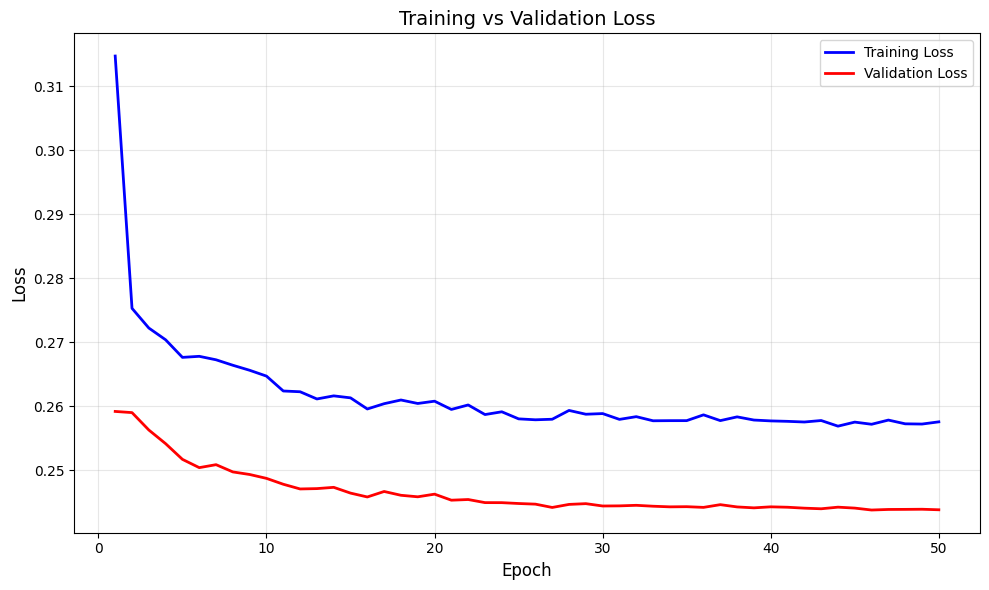

FOLD 3/5
Epoch 1/50, Train Loss: 0.3212, Val Loss: 0.2490
Epoch 11/50, Train Loss: 0.2592, Val Loss: 0.2344
Epoch 21/50, Train Loss: 0.2569, Val Loss: 0.2339
Epoch 31/50, Train Loss: 0.2547, Val Loss: 0.2336
Epoch 41/50, Train Loss: 0.2535, Val Loss: 0.2322
Epoch 50/50, Train Loss: 0.2537, Val Loss: 0.2319


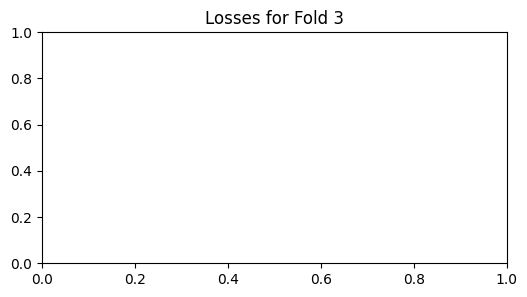

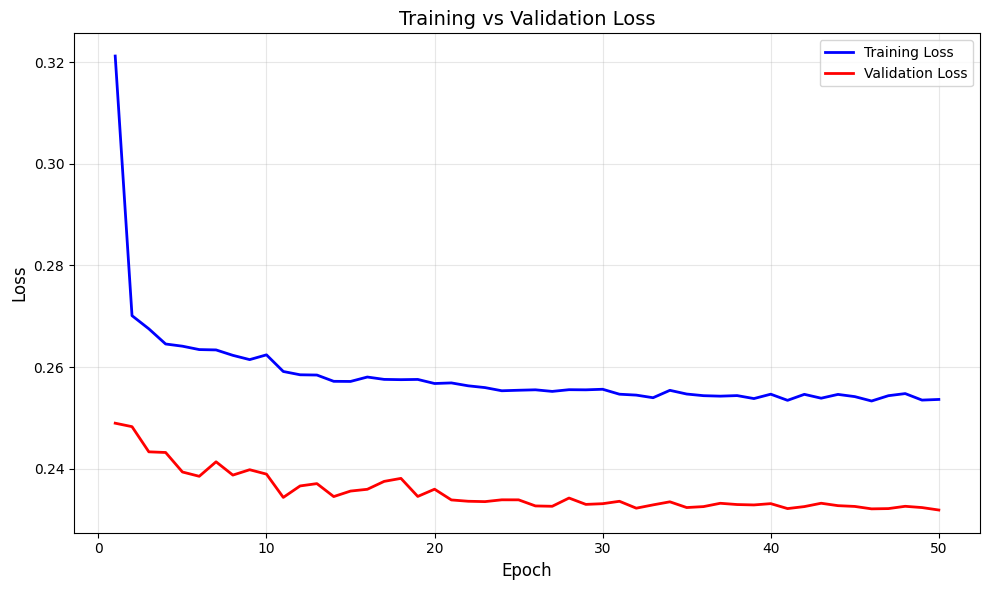

FOLD 4/5
Epoch 1/50, Train Loss: 0.3283, Val Loss: 0.2497
Epoch 11/50, Train Loss: 0.2591, Val Loss: 0.2403
Epoch 21/50, Train Loss: 0.2556, Val Loss: 0.2389
Epoch 31/50, Train Loss: 0.2538, Val Loss: 0.2372
Epoch 41/50, Train Loss: 0.2533, Val Loss: 0.2366
Epoch 50/50, Train Loss: 0.2532, Val Loss: 0.2362


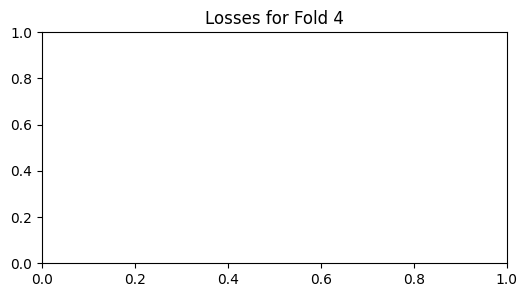

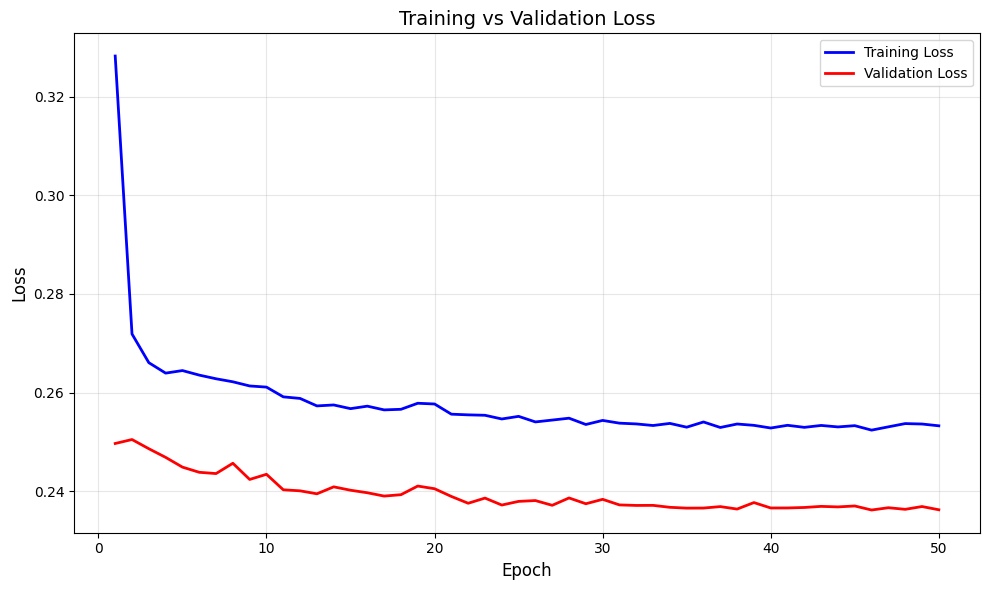

FOLD 5/5
Epoch 1/50, Train Loss: 0.3629, Val Loss: 0.2449
Epoch 11/50, Train Loss: 0.2562, Val Loss: 0.2355
Epoch 21/50, Train Loss: 0.2526, Val Loss: 0.2336
Epoch 31/50, Train Loss: 0.2513, Val Loss: 0.2332
Epoch 41/50, Train Loss: 0.2495, Val Loss: 0.2323
Epoch 50/50, Train Loss: 0.2497, Val Loss: 0.2323


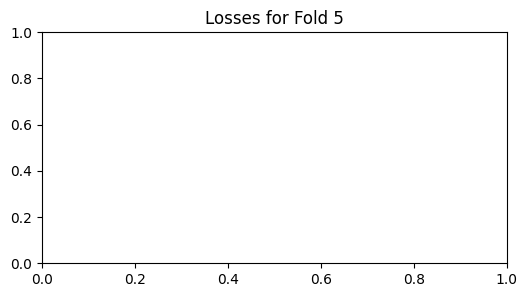

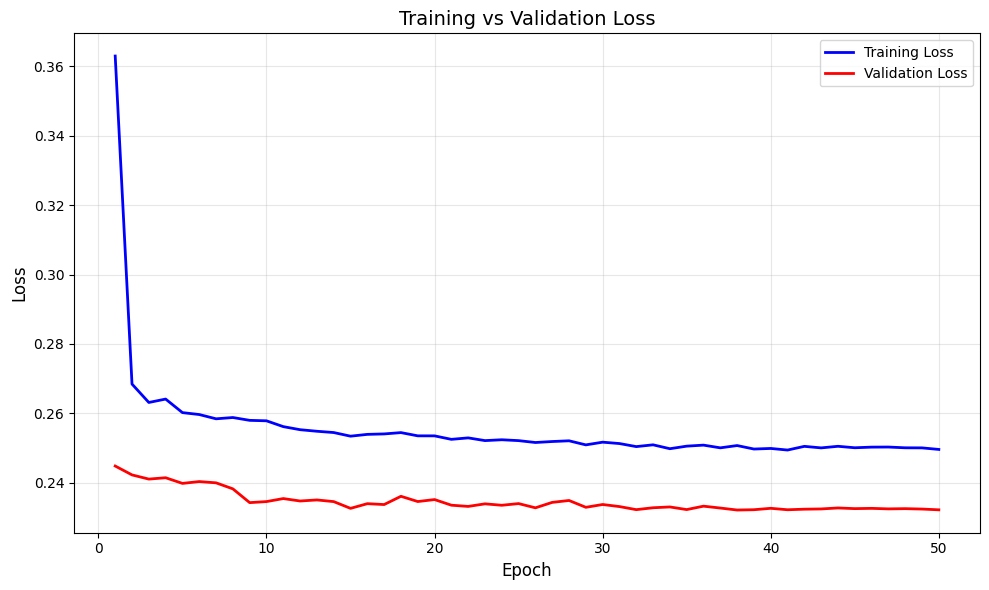

In [43]:
from model import MLP
import matplotlib.pyplot as plt

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=42)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, df_train['target'])):
    print(f"FOLD {fold + 1}/{n_splits}")
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    clf = MLP(X_train_fold, y_train_fold, 0.005, 0.75)
    clf.train(256, 50, X_val_fold, y_val_fold)
    plt.figure(figsize=(6, 3))
    plt.title(f"Losses for Fold {fold + 1}")
    clf.plot_losses()
    plt.show()

In [6]:
def evaluate(y_pred, y_true):
    y_true = y_true.to_numpy().reshape(-1, 1)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

In [44]:
clf = MLP(X_train, y_train, 0.005, 0.75)
clf.train(256, 50, X_train, y_train)

Epoch 1/50, Train Loss: 0.3072, Val Loss: 0.2510
Epoch 11/50, Train Loss: 0.2609, Val Loss: 0.2405
Epoch 21/50, Train Loss: 0.2576, Val Loss: 0.2373
Epoch 31/50, Train Loss: 0.2563, Val Loss: 0.2355
Epoch 41/50, Train Loss: 0.2556, Val Loss: 0.2359
Epoch 50/50, Train Loss: 0.2554, Val Loss: 0.2357


In [7]:
y_pred = clf.predict(X_val)
y_pred_binary = (y_pred >= 0.5).astype(int)
accuracy = evaluate(y_pred_binary, y_val)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9108


In [46]:
y_test_pred = clf.predict(X_test)
submission = pd.DataFrame({'ID_code': test['ID_code'], 'target': y_test_pred.flatten()})
submission.to_csv(r'C:\Users\User\Documents\Code\ML\MLP_From_Scratch\data\submission.csv', index=False)